In [78]:
import pandas as pd
import numpy as np
import os
import json
import logging
import datetime
import requests
import pandas_ta as ta

from typing import Literal
from typing_extensions import TypedDict
from duckduckgo_search import DDGS

from langchain_core.tools import Tool, tool
from langchain_experimental.utilities import PythonREPL
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END, START, StateGraph
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.prebuilt import create_react_agent

ImportError: cannot import name '__all__' from 'pandas_ta.utils' (/Users/marco/Documents/project/machine_learning/langgraph_basic/.venv_lang/lib/python3.9/site-packages/pandas_ta/utils/__init__.py)

# Create custom function

In [2]:
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18")

In [29]:
def get_ohlc_4h(coin_id:str, vs_currency:str = 'usd'):
    """
    Mengambil data OHLC dalam interval 4 jam dari CoinGecko API.
    
    Parameters:
        coin_id (str): ID cryptocurrency (default: "bitcoin").
        vs_currency (str): Mata uang yang digunakan (default: "usd").
    
    Returns:
        pd.DataFrame: DataFrame berisi data OHLC.
    """
    # Endpoint untuk mengambil data OHLC
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/ohlc"
    params = {
        "vs_currency": vs_currency,
        "days": "1"  # Ambil data 1 hari terakhir (interval 4 jam)
    }

    # Mengirim request ke API
    response = requests.get(url, params=params)

    # Mengecek status response
    if response.status_code == 200:
        data = response.json()  # Mengubah response ke format JSON

        # Konversi data ke DataFrame
        df = pd.DataFrame(data, columns=["timestamp", "open", "high", "low", "close"])

        # Konversi timestamp ke datetime
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

        # Set timestamp sebagai index
        df.set_index("timestamp", inplace=True)

        return df
    else:
        raise Exception(f"Error fetching OHLC data: {response.status_code}")

# # Contoh penggunaan
# if __name__ == "__main__":
#     try:
#         ohlc_data = get_ohlc_4h(coin_id="bitcoin", vs_currency="usd")
#         print(ohlc_data)
#     except Exception as e:
#         print(e)

In [30]:
bitcoin = get_ohlc_4h(coin_id="bitcoin")
print(bitcoin.shape)

(48, 4)


In [31]:
ethereum = get_ohlc_4h(coin_id="bitcoin")
print(ethereum.shape)

(48, 4)


In [36]:
bitcoin["date"] = pd.to_datetime(bitcoin.index)
bitcoin["symbol"] = "BTC"

ethereum["date"] = pd.to_datetime(ethereum.index)
ethereum["symbol"] = "ETH"

In [38]:
bitcoin.to_csv('bitcoin.csv', index=False)
ethereum.to_csv('ethereum.csv', index=False)

In [39]:
price_df = pd.concat([bitcoin, ethereum], axis=0).reset_index(drop=True)
price_df.head()

,open,high,low,close,date,symbol
0,82655.0,83251.0,82655.0,83021.0,2025-03-09 20:30:00,BTC
1,83169.0,83348.0,82985.0,82985.0,2025-03-09 21:00:00,BTC
2,83066.0,83066.0,82024.0,82024.0,2025-03-09 21:30:00,BTC
3,82113.0,82240.0,81877.0,81877.0,2025-03-09 22:00:00,BTC
4,81726.0,81774.0,81525.0,81564.0,2025-03-09 22:30:00,BTC


In [40]:
price_df.symbol.value_counts()

symbol
BTC    48
ETH    48
Name: count, dtype: int64

In [42]:
price_df = price_df[["date", "symbol", "open", "high", "low", "close"]]
price_df = price_df.sort_values(by="date").reset_index(drop=True)
price_df.tail()

,date,symbol,open,high,low,close
91,2025-03-10 19:00:00,BTC,78354.0,78581.0,77721.0,77721.0
92,2025-03-10 19:30:00,ETH,77495.0,78859.0,77495.0,78859.0
93,2025-03-10 19:30:00,BTC,77495.0,78859.0,77495.0,78859.0
94,2025-03-10 20:00:00,BTC,78799.0,79423.0,78746.0,78906.0
95,2025-03-10 20:00:00,ETH,78799.0,79423.0,78746.0,78906.0


In [49]:
price_df.to_csv('price.csv', index=False)

In [44]:
def search(keyword: str, max_results=100) -> pd.DataFrame:
    search_tool = DDGS()
    results = search_tool.news(
        keywords=keyword, safesearch="off", timelimit="m", max_results=max_results
    )
    df = pd.DataFrame.from_records(results)
    df["date"] = pd.to_datetime(df.date)
    return df.sort_values(by="date", ascending=False)

In [46]:
crypto_news_df = search(keyword="Cryptocurrency")
btc_news_df = search(keyword="Bitcoin")
eth_news_df = search(keyword="Ethereum")
crypto_news_df.shape, btc_news_df.shape, eth_news_df.shape

((77, 6), (100, 6), (100, 6))

In [47]:
crypto_news_df["symbol"] = None
btc_news_df["symbol"] = "BTC"
eth_news_df["symbol"] = "ETH"

news_df = pd.concat([crypto_news_df, btc_news_df, eth_news_df], axis=0)
news_df = news_df.sort_values(by="date").reset_index(drop=True)
news_df.head()

,date,title,body,url,image,source,symbol
0,2025-02-09 00:00:00+00:00,Bitcoin's role as a reserve asset gains tracti...,US states are introducing Bitcoin reserve bill...,https://cointelegraph.com/news/bitcoin-reserve...,,CoinTelegraph,BTC
1,2025-02-10 00:00:00+00:00,Bitcoin's meme ICO going viral 24 hours before...,Bitcoin is about to get a meme-fueled upgrade:...,https://cointelegraph.com/press-releases/bitco...,,CoinTelegraph,BTC
2,2025-02-11 17:43:00+00:00,A research firm says the speculative mania in ...,The firm initiated a bullish stance on bitcoin...,https://markets.businessinsider.com/news/curre...,,Business Insider,BTC
3,2025-02-12 00:01:00+00:00,Bitcoin price could reach $1.5M by 2030 — Cath...,"Bitcoin may reach $1.5 million by 2030, says A...",https://cointelegraph.com/news/bitcoin-odds-1-...,,CoinTelegraph,BTC
4,2025-02-15 13:45:00+00:00,"Ethereum Staking ETFs Coming By 2025, Says Lid...","ILLUSTRATION - 23 April 2024, Baden-Württember...",https://www.forbes.com/sites/boazsobrado/2025/...,,Forbes,ETH


In [48]:
news_df.to_csv('news.csv', index=False)

# Tools

In [58]:
@tool
def search_coins(coin_id: str):
    """Return Price DataFrame that depends on coin_id. e.g BTC, ETH, etc"""
    df = pd.read_csv('price.csv')
    df = df[df['symbol'] == coin_id]
    
    return df

@tool
def search_news(coin_id: str):
    """Return News DataFrame that depends on coin_id. e.g BTC, ETH, etc"""
    df = pd.read_csv('news.csv')
    df = df[df['symbol'] == coin_id]

    return df[['date', 'title', 'body']]

In [63]:
search_coins('ETH') # 82655.0	83251.0	82655.0	83021.0

,date,symbol,open,high,low,close
1,2025-03-09 20:30:00,ETH,82655.0,83251.0,82655.0,83021.0
2,2025-03-09 21:00:00,ETH,83169.0,83348.0,82985.0,82985.0
4,2025-03-09 21:30:00,ETH,83066.0,83066.0,82024.0,82024.0
7,2025-03-09 22:00:00,ETH,82113.0,82240.0,81877.0,81877.0
8,2025-03-09 22:30:00,ETH,81726.0,81774.0,81525.0,81564.0
10,2025-03-09 23:00:00,ETH,81136.0,81220.0,80559.0,80559.0
13,2025-03-09 23:30:00,ETH,80399.0,80852.0,80183.0,80776.0
14,2025-03-10 00:00:00,ETH,80618.0,80928.0,80486.0,80751.0
16,2025-03-10 00:30:00,ETH,80675.0,81176.0,80549.0,80791.0
18,2025-03-10 01:00:00,ETH,80482.0,81450.0,80124.0,81450.0


In [64]:
search_news('ETH')


,date,title,body
4,2025-02-15 13:45:00+00:00,"Ethereum Staking ETFs Coming By 2025, Says Lid...","ILLUSTRATION - 23 April 2024, Baden-Württember..."
7,2025-02-17 23:59:00+00:00,Is Ethereum bottoming out at last? Analysts we...,Popular analyst Crypto Yodhha shared a chart t...
13,2025-02-20 23:59:00+00:00,Ethereum Foundation wants a social media guru ...,The Ethereum Foundation is looking to boost it...
16,2025-02-22 00:00:00+00:00,Ethereum 'Roll Back' Suggestion Has Sparked Cr...,"On Friday, cryptocurrency exchange Bybit was a..."
29,2025-02-28 14:09:09+00:00,Ethereum Foundation forms external council to ...,The Ethereum Foundation tagged 15 individuals ...
...,...,...,...
260,2025-03-10 18:00:00+00:00,Missed Bitcoin and Ethereum? Don't Miss Kaanch...,"In the world of cryptocurrency, one thing rema..."
264,2025-03-10 18:24:00+00:00,"Cryptocurrencies Price Prediction: Ethereum, B...","Ethereum (ETH) is down 2% on Monday, trading n..."
267,2025-03-10 18:51:00+00:00,"Ethereum Price Crashes Below $2,000 - Here's W...",We could still easily be looking at an Ethereu...
270,2025-03-10 19:00:00+00:00,Sony's Aibo Robot Dog Is Back—In Ethereum NFT ...,Nearly 10 million free Aibo NFTs have been min...


# Metrics

## Indicators

In [65]:
dates = pd.date_range(start="2023-01-01", periods=100, freq="D")
price = np.cumsum(np.random.randn(100)) + 100  # Random walk

df = pd.DataFrame({"Date": dates, "Price": price})
df.set_index("Date", inplace=True)

In [66]:
df

,Price
Date,
2023-01-01,97.882974
2023-01-02,97.750582
2023-01-03,95.642153
2023-01-04,95.569887
2023-01-05,96.153077
...,...
2023-04-06,107.947616
2023-04-07,108.614808
2023-04-08,109.313542


## RSI

In [67]:
def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()

    rs = gain / loss
    return 100 - (100 / (1 + rs))


df["RSI"] = calculate_rsi(df["Price"])

In [68]:
df

,Price,RSI
Date,,
2023-01-01,97.882974,NaN
2023-01-02,97.750582,NaN
2023-01-03,95.642153,NaN
2023-01-04,95.569887,NaN
2023-01-05,96.153077,NaN
...,...,...
2023-04-06,107.947616,69.346010
2023-04-07,108.614808,71.632048
2023-04-08,109.313542,68.977630


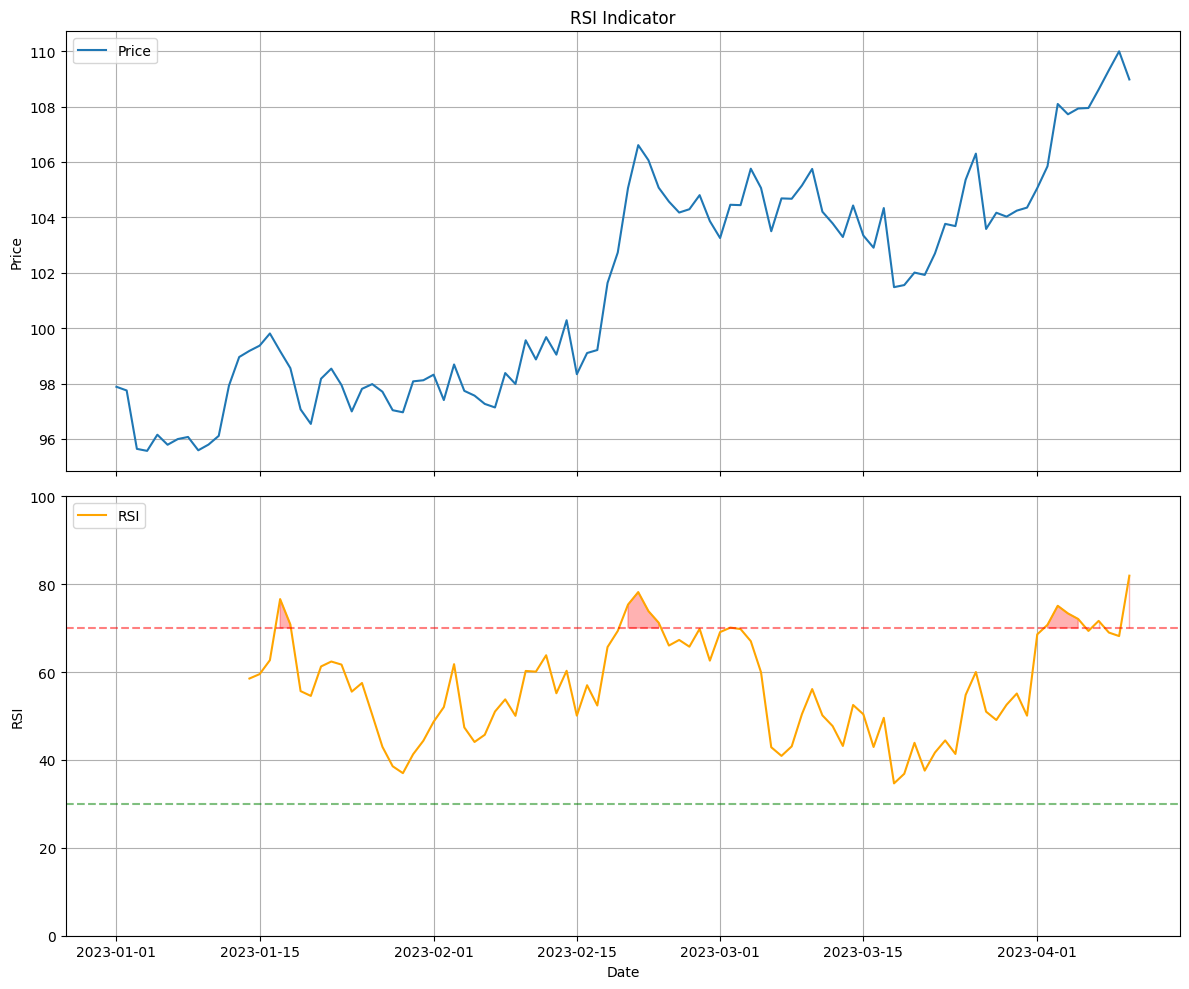

In [71]:
import  matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ax1.plot(df.index, df["Price"], label="Price")
ax1.set_title("RSI Indicator")
ax1.set_ylabel("Price")
ax1.legend(loc="upper left")
ax1.grid(True)

ax2.plot(df.index, df["RSI"], label="RSI", color="orange")
ax2.axhline(y=70, color="red", linestyle="--", alpha=0.5)
ax2.axhline(y=30, color="green", linestyle="--", alpha=0.5)
ax2.fill_between(
    df.index, df["RSI"], 70, where=(df["RSI"] >= 70), color="red", alpha=0.3
)
ax2.fill_between(
    df.index, df["RSI"], 30, where=(df["RSI"] <= 30), color="green", alpha=0.3
)
ax2.set_ylabel("RSI")
ax2.set_ylim(0, 100)
ax2.legend(loc="upper left")
ax2.grid(True)

plt.xlabel("Date")
plt.tight_layout()
plt.show()

## MACD

In [72]:
df["EMA12"] = df["Price"].ewm(span=12, adjust=False).mean()
df["EMA26"] = df["Price"].ewm(span=26, adjust=False).mean()

df["MACD"] = df["EMA12"] - df["EMA26"]
df["Signal Line"] = df["MACD"].ewm(span=9, adjust=False).mean()
df["Histogram"] = df["MACD"] - df["Signal Line"]

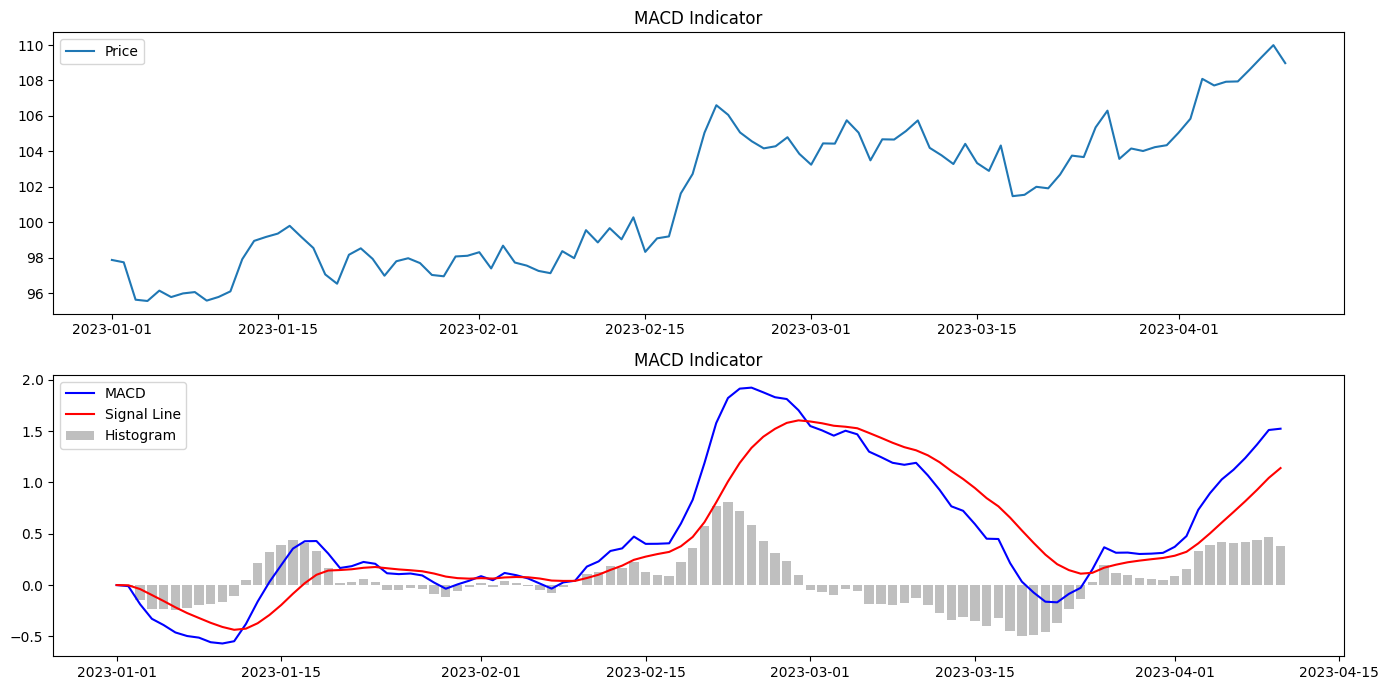

In [73]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(df.index, df["Price"], label="Price")
plt.title("MACD Indicator")
plt.legend(loc="upper left")

plt.subplot(2, 1, 2)
plt.plot(df.index, df["MACD"], label="MACD", color="blue")
plt.plot(df.index, df["Signal Line"], label="Signal Line", color="red")
plt.bar(df.index, df["Histogram"], label="Histogram", color="gray", alpha=0.5)
plt.title("MACD Indicator")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show();

In [77]:
def add_indicators(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()
    macd_df = ta.macd(data["close"])
    bbands_df = ta.bbands(data["close"])

    data["ma_50"] = data["close"].rolling(50).mean()
    data["ma_200"] = data["close"].rolling(200).mean()
    data["rsi"] = ta.rsi(data["close"])
    data["macd"], data["macd_signal"], data["macd_histogram"] = (
        macd_df.iloc[:, 0],
        macd_df.iloc[:, 1],
        macd_df.iloc[:, 2],
    )
    data["bb_lower"], data["bb_middle"], data["bb_upper"] = (
        bbands_df.iloc[:, 0],
        bbands_df.iloc[:, 1],
        bbands_df.iloc[:, 2],
    )
    return data